In [1]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg) if 'loss' in metric_type else np.max(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'train_target_misclassification': get_mean_metrics(models, 'train_target_misclassification'),
        'test_target_misclassification': get_mean_metrics(models, 'test_target_misclassification')
    }

    return baseline_metrics

In [2]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [3]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_AB35IN_25R_19_01',
 'MNIST_AB__IN_25R_20_00',
 'BACKDOOR_TEST_04',
 'BACKDOOR_TEST_03',
 'BACKDOOR_TEST_02',
 'BACKDOOR_TEST_01',
 'MNIST_GBP100_25R_16_04',
 'MNIST_GBP100_25R_18_02',
 'MNIST_GBP100_25R_19_01',
 'MNIST_GBP010_25R_16_04',
 'MNIST_GBP010_25R_18_02',
 'MNIST_GBP010_25R_19_01',
 'MNIST_LFB_25R_16_04_V2',
 'MNIST_LFB_25R_18_02_V2',
 'MNIST_LFB_25R_19_01_V2',
 'TEST_5_WITH_EPOCH_01',
 'TEST_EPOCH_04',
 'TEST_EPOCH_03',
 'TEST_EPOCH_02',
 'TEST_EPOCH_01',
 'MNIST_GBM001_25R_18_02',
 'MNIST_GBM001_25R_19_01',
 'MNIST_BASE_25R_20_00']

In [4]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_AB35IN_25R_19_01


In [5]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_AB__IN_25R_20_00


In [6]:
models = client.list_models(session_id)

num_rounds = models['count']
# num_rounds

# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [7]:
# client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']

In [8]:
# json.loads(client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']['data'])

In [9]:
# for round in range(num_rounds):
#     for client_model in client.list_validations(modelId = model_trail[round]['model']).keys():
#         print(json.loads(client.list_validations(modelId = model_trail[round]['model'])[client_model]['data'])['train_target_misclassification'])

In [10]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'train_target_misclassification': json.loads(worker_result['data'])['train_target_misclassification'],
            'test_target_misclassification': json.loads(worker_result['data'])['test_target_misclassification'],
            'train_target_prediction_dist': json.loads(worker_result['data'])['train_target_prediction_dist'],
            'test_target_prediction_dist': json.loads(worker_result['data'])['test_target_prediction_dist']
        }
        
        validations.append(validation)

In [11]:
validations[0]

{'model_committed_at': 'Sun, 05 May 2024 14:53:44 GMT',
 'session_id': 'MNIST_AB35IN_25R_19_01',
 'model': '42585d08-2573-4e28-8e9a-481b68dad1ae',
 'client_name': 'benign_client11',
 'client_role': 'WORKER',
 'client_type': 'benign',
 'train_target_misclassification': 1.0,
 'test_target_misclassification': 1.0,
 'train_target_prediction_dist': [0, 0, 0, 295, 5, 0, 0, 0, 0, 0],
 'test_target_prediction_dist': [0, 0, 0, 49, 1, 0, 0, 0, 0, 0]}

In [12]:
graph_data = {
    'train_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'train_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_train_target_misclassification': [],
    'overall_test_target_misclassification': [],
    'overall_train_target_prediction_dist': [],
    'overall_test_target_prediction_dist': []
}

In [13]:
for validation in validations:
    graph_data['train_target_misclassification'][validation['client_name']]['data'].append(validation['train_target_misclassification'])
    graph_data['test_target_misclassification'][validation['client_name']]['data'].append(validation['test_target_misclassification'])
    graph_data['train_target_prediction_dist'][validation['client_name']]['data'].append(validation['train_target_prediction_dist'])
    graph_data['test_target_prediction_dist'][validation['client_name']]['data'].append(validation['test_target_prediction_dist'])

In [14]:
graph_data['train_target_prediction_dist']

{'benign_client18': {'data': [[0, 0, 0, 291, 14, 0, 0, 0, 0, 0],
   [0, 0, 0, 298, 5, 0, 0, 0, 0, 2],
   [0, 0, 0, 258, 8, 0, 0, 0, 0, 39],
   [0, 0, 9, 172, 4, 0, 0, 0, 0, 120],
   [0, 2, 43, 117, 3, 0, 0, 0, 0, 140],
   [1, 8, 80, 87, 2, 0, 0, 0, 7, 120],
   [8, 25, 83, 76, 2, 0, 0, 14, 20, 77],
   [11, 43, 57, 69, 2, 0, 1, 39, 57, 26],
   [10, 39, 31, 61, 4, 0, 3, 34, 115, 8],
   [6, 27, 22, 57, 4, 0, 6, 19, 158, 6],
   [2, 21, 13, 50, 4, 3, 6, 14, 185, 7],
   [2, 18, 12, 40, 4, 3, 6, 12, 200, 8],
   [2, 13, 13, 34, 4, 3, 4, 12, 213, 7],
   [2, 12, 13, 30, 4, 4, 4, 9, 219, 8],
   [2, 12, 10, 27, 3, 3, 4, 9, 226, 9],
   [3, 12, 8, 23, 3, 3, 4, 9, 231, 9],
   [3, 12, 8, 19, 3, 2, 4, 7, 237, 10],
   [3, 11, 8, 18, 3, 2, 4, 6, 239, 11],
   [2, 11, 8, 15, 3, 4, 4, 6, 241, 11],
   [1, 10, 8, 15, 3, 5, 3, 6, 243, 11],
   [1, 10, 8, 15, 3, 6, 3, 5, 244, 10],
   [1, 10, 8, 12, 3, 6, 3, 5, 248, 9],
   [1, 10, 8, 11, 3, 6, 3, 5, 249, 9],
   [1, 10, 8, 12, 3, 6, 3, 5, 248, 9],
   [1, 11, 8, 11,

In [15]:
graph_data['overall_train_target_misclassification'] = [np.mean([graph_data['train_target_misclassification'][key]['data'][i] for key in graph_data['train_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_target_misclassification'] = [np.mean([graph_data['test_target_misclassification'][key]['data'][i] for key in graph_data['test_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_train_target_prediction_dist'] = [np.sum([graph_data['train_target_prediction_dist'][key]['data'][i] for key in graph_data['train_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]
graph_data['overall_test_target_prediction_dist'] = [np.sum([graph_data['test_target_prediction_dist'][key]['data'][i] for key in graph_data['test_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]

In [16]:
graph_data['overall_test_target_prediction_dist']

[[0, 0, 0, 952, 22, 0, 0, 0, 0, 0],
 [0, 0, 0, 955, 11, 0, 0, 0, 0, 8],
 [0, 0, 0, 718, 13, 0, 0, 0, 0, 243],
 [0, 0, 16, 478, 6, 0, 0, 0, 6, 468],
 [0, 1, 113, 313, 5, 0, 0, 0, 5, 537],
 [16, 20, 205, 247, 4, 0, 0, 5, 8, 469],
 [51, 59, 228, 220, 4, 0, 0, 66, 29, 317],
 [74, 97, 181, 191, 5, 0, 0, 199, 127, 100],
 [69, 94, 102, 170, 9, 0, 3, 151, 334, 42],
 [56, 74, 56, 138, 17, 2, 6, 97, 492, 36],
 [46, 48, 40, 124, 16, 10, 18, 66, 574, 32],
 [37, 41, 28, 109, 15, 16, 19, 56, 624, 29],
 [34, 37, 24, 100, 19, 16, 17, 49, 650, 28],
 [28, 35, 22, 87, 20, 20, 15, 43, 673, 31],
 [24, 32, 24, 77, 20, 24, 13, 37, 689, 34],
 [19, 32, 19, 71, 20, 29, 15, 35, 702, 32],
 [17, 30, 17, 68, 22, 29, 15, 29, 712, 35],
 [16, 29, 16, 62, 20, 30, 16, 27, 719, 39],
 [15, 27, 16, 58, 20, 33, 16, 25, 727, 37],
 [14, 24, 15, 55, 22, 35, 15, 23, 737, 34],
 [14, 19, 14, 52, 22, 36, 14, 20, 750, 33],
 [12, 19, 12, 50, 21, 39, 16, 19, 753, 33],
 [12, 18, 10, 47, 20, 40, 16, 18, 759, 34],
 [11, 17, 10, 43, 20, 

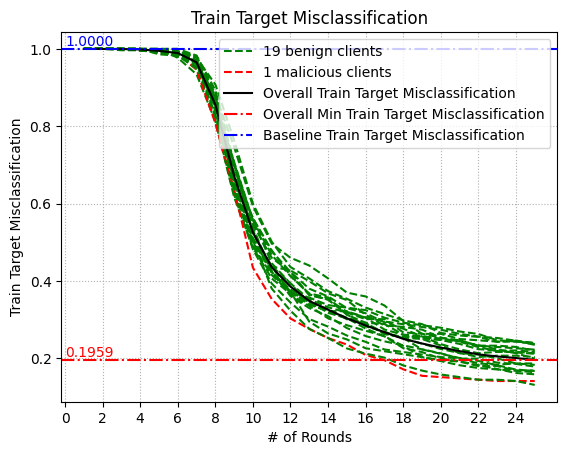

In [17]:
x = range(1, num_rounds + 1)
metric_type = "train_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

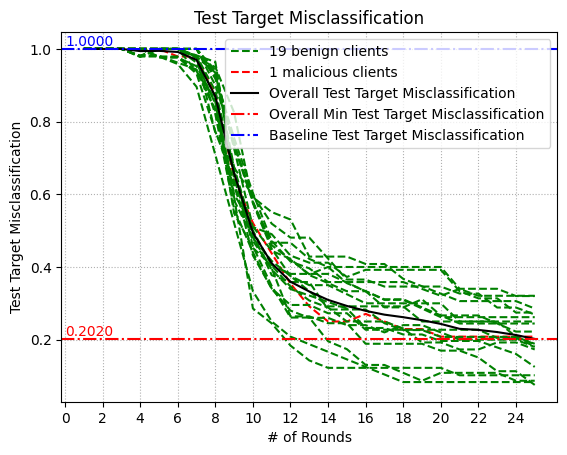

In [18]:
x = range(1, num_rounds + 1)
metric_type = "test_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()